In [15]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as geom_nn
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.data import InMemoryDataset
from torch_geometric.utils import from_networkx

# Generating a cycle dataset

Here we generate a dataset containing pairs of graphs that are not distinguishable by the 1-WL isomorphism test.
Later we will use GNNs to learn to tell them apart.

In [2]:
graphs_nx = []
graphs_is_cycle = []  # keeps track if a graph is a cycle or disjoint
for n in range(6, 16):
    g_cyc = nx.Graph()
    g_cyc.add_nodes_from(range(n))
    g_cyc.add_edges_from([(x, x+1) for x in range(n-1)] + [(n-1, 0)])  # connect nodes to cycle
    
    for split_n in range(3,n-2):
        g_split = nx.Graph()
        g_cyc.add_nodes_from(range(n))
        g_split.add_edges_from([(x, x+1) for x in range(split_n-1)] + [(split_n-1, 0)])  # first cycle of size split_n
        g_split.add_edges_from([(x, x+1) for x in range(split_n, n-1)] + [(n-1, split_n)])  # dsecond cycle of remaing nodes
        graphs_nx.append(g_split)
        graphs_is_cycle.append(False)
        graphs_nx.append(g_cyc)  # add g_cyc every time to maintain balance
        graphs_is_cycle.append(True)
        
        

In [3]:
# Converting the graphs to torch_geometric.data.Data objects
graphs = [from_networkx(g) for g in graphs_nx]
for i_g, g in enumerate(graphs):
    g.x = torch.zeros((g.num_nodes, 50))  # uniform x/features
    g.y = torch.tensor([1 if graphs_is_cycle[i_g] else 0])  # target label indicating whether graph is cycle or disjoint

# Building a GNN

In [4]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, depth, mp_layer=None):
        super().__init__()
        # the type of message passing layer used throughout the net
        self.mp_layer = geom_nn.GCNConv if mp_layer is None else mp_layer
        self.pool = geom_nn.global_mean_pool
        self.mp_layers = nn.ModuleList()
        
        # standard mlp used after message passing layers
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid())
        
        # add message passing layers
        self.mp_layers.append(self.mp_layer(input_dim, hidden_dim))
        for i in range(depth-1):
            self.mp_layers.append(self.mp_layer(hidden_dim, hidden_dim))
            
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for l in self.mp_layers:
            x = l(x, edge_index)
            x = F.relu(x)
        x = self.pool(x, batch)
        x = self.post_mp(x)
        return x
    
    def loss(self, pred, label):
        return torch.nn.functional.binary_cross_entropy(pred, label)
        

In [35]:
def plot_progress(x, y):
    plt.plot(x, y)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    plt.clf()

In [41]:
def train(dataset, nb_epochs=50, rni=False, lr=0.01, test_data=None, model_depth=16):
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    if rni:
        model = RNINet(dataset[0].num_node_features, 50, 1, depth=model_depth)
    else:
        model = Net(dataset[0].num_node_features, 50, 1, depth=model_depth)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    progress_accs = []
    progress_epochs = []
    for epoch in range(nb_epochs):
        total_loss = 0
        model.train()
        for batch in train_loader:
            opt.zero_grad()
            pred = model(batch).flatten()
            label = batch.y.to(torch.float32)
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        if not test_data is None:  # perform testing to track progress
            if epoch % 10 == 0:
                test_acc = test(model, test_data)
                progress_accs.append(test_acc)
                progress_epochs.append(epoch)
    if not test_data is None:
        plot_progress(progress_epochs, progress_accs)
        
    return model

In [6]:
def test(model, dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    model.eval()
    
    correct = 0
    incorrect = 0
    tot = 0
    for data in loader:
        with torch.no_grad():
            pred = model(data).flatten()
            label = data.y
            pred = [0 if p <= 0.5 else 1 for p in pred]  # 0 if prediction <= 0.5, 1 othwerwise
            correct_i = np.equal(pred, label)
            correct += np.array(correct_i).sum().item()
    return correct / len(loader.dataset)

In [28]:
def cross_validate(data, k=5, plot_progress=False, **kwargs):
    # We perform k-fold cross validation
    chunks = []
    chunk_size = int(len(data)/k)
    # split the data
    for i in range(k):
        if i*chunk_size+chunk_size <= len(data):
            chunks.append(data[i*chunk_size:(i+1)*chunk_size])
        else:
            chunks.append(data[i*chunk_size:])
    # perform training and testing
    accuracies = []
    for i, chunk in enumerate(chunks):
        test_set = chunk
        train_set = [x for l in (chunks[0:i] + chunks[i+1:]) for x in l]
        if plot_progress:
            model = train(train_set, test_data=test_set, **kwargs)
        else:
            model = train(train_set, **kwargs)
        acc = test(model, test_set)
        accuracies.append(acc)
        print('Accuracy at test-chunk {}: {}'.format(i, acc))
    return np.array(accuracies).sum() / len(accuracies)

Now we can test the net. It should not be able to distinguish the graph-types.

In [26]:
# we exprect a test accuracy of 0.5, since these types of graphs can't be distinguished by the net
avg_acc = cross_validate(graphs)
print(avg_acc)

Accuracy at test-chunk 0: 0.5
Accuracy at test-chunk 1: 0.5
Accuracy at test-chunk 2: 0.5
Accuracy at test-chunk 3: 0.5
Accuracy at test-chunk 4: 0.5
0.5


# Adding Randomness (RNI)

Random Node Initialization assign random features to each node in a graph, improving the GNN's expressive power. This should allow the net to distinguish between the graph types.

In [9]:
# Initializes 50% of node fearures randomly, to increase expressive power
class RNINet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, depth, mp_layer=None):
        super().__init__()
        # the type of message passing layer used throughout the net
        self.mp_layer = geom_nn.GCNConv if mp_layer is None else mp_layer
        self.pool = geom_nn.global_mean_pool
        self.mp_layers = nn.ModuleList()
        
        # standard mlp used after message passing layers
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid())
        
        # add message passing layers
        self.mp_layers.append(self.mp_layer(input_dim, hidden_dim))
        for i in range(depth-1):
            self.mp_layers.append(self.mp_layer(hidden_dim, hidden_dim))
            
    def rni(self, x):
        init_len = len(x[0])
        random_len = int(len(x[0])/2)
        random_samples = torch.normal(mean=0, std=1, size=(len(x), random_len))
        x_half = x.transpose(0,1)[init_len-random_len:].transpose(0,1)
        x_rni = torch.cat((x_half,random_samples), 1)
        assert len(x_rni[0]) == init_len
        return x_rni
            
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # RNI
        x = self.rni(x)
        for l in self.mp_layers:
            x = l(x, edge_index)
            x = F.relu(x)
        x = self.pool(x, batch)
        x = self.post_mp(x)
        return x
    
    def loss(self, pred, label):
        return torch.nn.functional.binary_cross_entropy(pred, label)

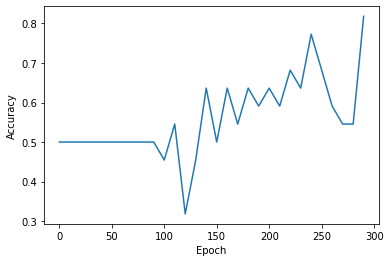

In [25]:
# train with RNI. We expect the accuracy to go up, since expressive power of the model was increased
model = train(graphs[:int(0.8*len(graphs))], nb_epochs=300, rni=True, lr=0.0001, test_data=graphs[int(0.8*len(graphs)):])

# GNN Depth

Now we run cross validation on RNI-nets of different depths. i.e. with different numbers of message passing layers.

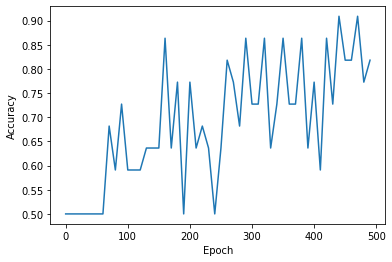

Accuracy at test-chunk 0: 0.6818181818181818


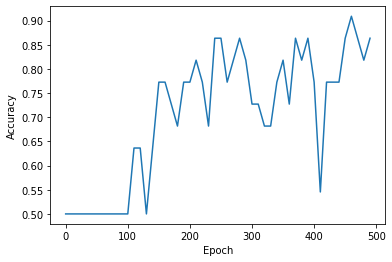

Accuracy at test-chunk 1: 0.8181818181818182


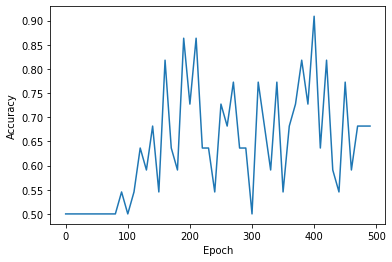

Accuracy at test-chunk 2: 0.7272727272727273


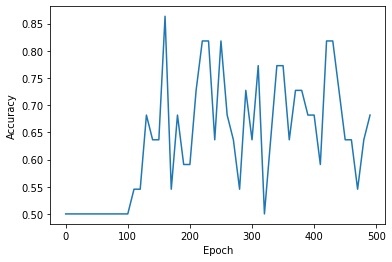

Accuracy at test-chunk 3: 0.6818181818181818


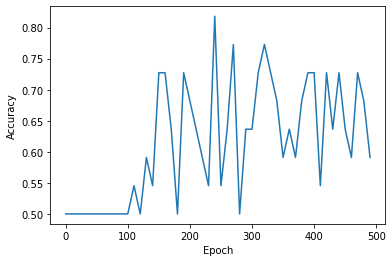

Accuracy at test-chunk 4: 0.5
0.6818181818181819


<Figure size 432x288 with 0 Axes>

In [36]:
# cross validatin with 16 mp layers
avg_acc = cross_validate(graphs, 5, True, rni=True, nb_epochs=500, lr=0.0001, model_depth=16)
print('\n\nAverage Accuracy: {}'.format(avg_acc))

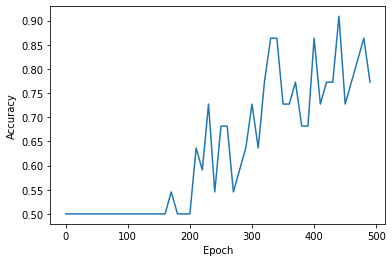

Accuracy at test-chunk 0: 0.7727272727272727


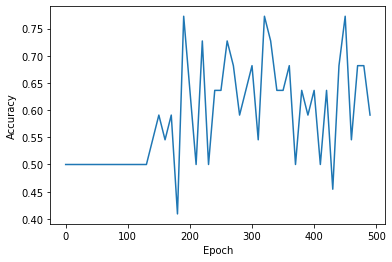

Accuracy at test-chunk 1: 0.5454545454545454


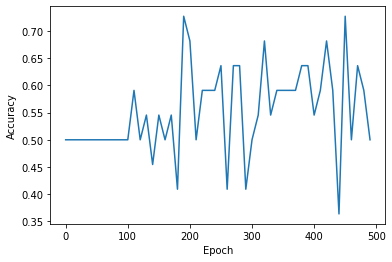

Accuracy at test-chunk 2: 0.5


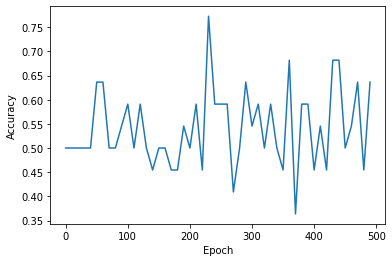

Accuracy at test-chunk 3: 0.5


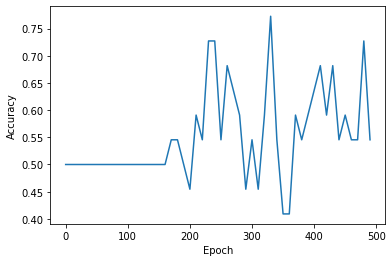

Accuracy at test-chunk 4: 0.7272727272727273


Average Accuracy: 0.6090909090909091


<Figure size 432x288 with 0 Axes>

In [38]:
# 8 mp layers
avg_acc = cross_validate(graphs, 5, True, rni=True, nb_epochs=500, lr=0.0001, model_depth=8)
print('\n\nAverage Accuracy: {}'.format(avg_acc))

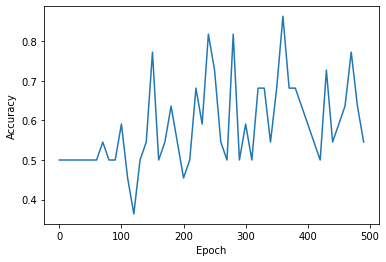

Accuracy at test-chunk 0: 0.45454545454545453


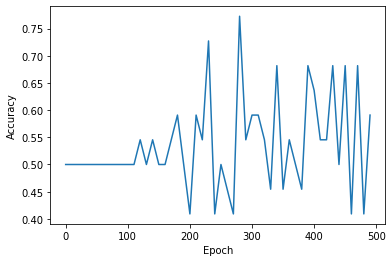

Accuracy at test-chunk 1: 0.5


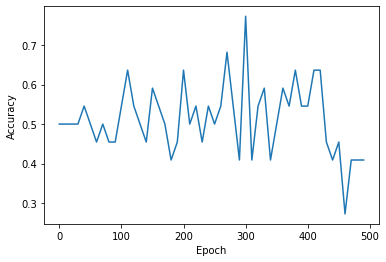

Accuracy at test-chunk 2: 0.5454545454545454


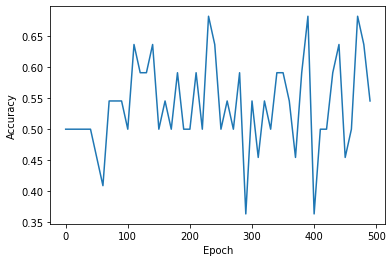

Accuracy at test-chunk 3: 0.5454545454545454


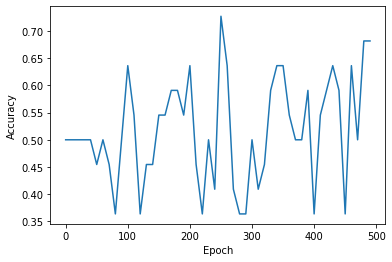

Accuracy at test-chunk 4: 0.5


Average Accuracy: 0.509090909090909


<Figure size 432x288 with 0 Axes>

In [39]:
# 4 mp layers
avg_acc = cross_validate(graphs, 5, True, rni=True, nb_epochs=500, lr=0.0001, model_depth=4)
print('\n\nAverage Accuracy: {}'.format(avg_acc))

Findings: In this experiment deeper nets perform better on average than their shallower counterparts. All nets are very volatile in their learning behaviour, and don't seem to stabalize within the 500 epochs. The deepest net seems to improve the most monotonically, especially with test chunks 0 and 1, which are the smaller graphs.